# Similarity Queries using Nmslib Tutorial

This tutorial is about using the ([Non-Metric Space Library (NMSLIB)](https://github.com/nmslib/nmslib "Link to nmslib repo")) library for similarity queries with a Word2Vec model built with gensim.

## Why use Nmslib?
The current implementation for finding k nearest neighbors in a vector space in gensim has linear complexity via brute force in the number of indexed documents, although with extremely low constant factors. The retrieved results are exact, which is an overkill in many applications: approximate results retrieved in sub-linear time may be enough. Nmslib can find approximate nearest neighbors much faster.
Compared to annoy, nmslib has more parameteres to control the build and query time and accuracy. Nmslib can achieve faster and more accurate nearest neighbors search than annoy. This figure shows a comparison between annoy and nmslib indexer with differents parameters. This shows nmslib is better than annoy.
![nmslib.png](nmslib.png)

## Prerequisites
Additional libraries needed for this tutorial:
- nmslib
- annoy
- psutil
- matplotlib

## Outline
1. Download Text8 Corpus
2. Build Word2Vec Model
3. Construct NmslibIndex with model & make a similarity query
4. Verify & Evaluate performance
5. Evaluate relationship of parameters to initialization/query time and accuracy, compared with annoy
6. Work with Google's word2vec C formats

In [5]:
# pip install watermark
%reload_ext watermark
%watermark -v -m -p gensim,numpy,scipy,psutil,matplotlib

CPython 3.6.0
IPython 7.5.0

gensim 3.7.3
numpy 1.16.2
scipy 1.2.1
psutil 5.6.3
matplotlib 3.1.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 10.0.0 (clang-1000.11.45.5)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


### 1. Download Text8 Corpus

In [2]:
import os.path
if not os.path.isfile('text8'):
    !wget -c https://mattmahoney.net/dc/text8.zip
    !unzip text8.zip

--2019-06-27 13:48:42--  https://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net... 67.195.197.75
Connecting to mattmahoney.net|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: 'text8.zip'

text8.zip           100%[=====================>]  29.89M   327KB/s   in 98s    

2019-06-27 13:50:21 (313 KB/s) - 'text8.zip' saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


#### Import & Set up Logging
I'm not going to set up logging due to the verbose input displaying in notebooks, but if you want that, uncomment the lines in the cell below.

In [6]:
LOGS = False

if LOGS:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### 2. Build Word2Vec Model

In [57]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus

# Using params from Word2Vec_FastText_Comparison

params = {
    'alpha': 0.05,
    'size': 100,
    'window': 5,
    'iter': 5,
    'min_count': 5,
    'sample': 1e-4,
    'sg': 1,
    'hs': 0,
    'negative': 5
}

model = Word2Vec(Text8Corpus('text8'), **params)
print(model)

Word2Vec(vocab=71290, size=100, alpha=0.05)


See the [Word2Vec tutorial](word2vec.ipynb) for how to initialize and save this model.

#### Comparing the traditional implementation, Annoy and Nmslib approximation

In [14]:
# Set up the model and vector that we are using in the comparison
from gensim.similarities.index import AnnoyIndexer
from gensim.similarities.nmslib import NmslibIndexer

model.init_sims()
annoy_index = AnnoyIndexer(model, 300)
nmslib_index = NmslibIndexer(model, {'M': 100, 'indexThreadQty': 1, 'efConstruction': 100}, {'efSearch': 10})

In [15]:
# Dry run to make sure both indices are fully in RAM
vector = model.wv.syn0norm[0]
print(model.most_similar([vector], topn=5, indexer=annoy_index))
print(model.most_similar([vector], topn=5, indexer=nmslib_index))
print(model.most_similar([vector], topn=5))

[('the', 1.0), ('of', 0.700629323720932), ('in', 0.6932138800621033), ('which', 0.6132444441318512), ('for', 0.6099657416343689)]
[('the', 0.9999999701976776), ('of', 0.91037717461586), ('in', 0.9058823883533478), ('a', 0.8834112882614136), ('and', 0.8790014386177063)]
[('the', 1.0000001192092896), ('of', 0.82075434923172), ('in', 0.811764657497406), ('a', 0.7668224573135376), ('and', 0.7580028772354126)]


In [7]:
import time
import numpy as np

In [8]:
def avg_query_time(annoy_index=None, queries=1000):
    """
    Average query time of a most_similar method over 1000 random queries,
    uses annoy if given an indexer
    """
    total_time = 0
    for _ in range(queries):
        rand_vec = model.wv.syn0norm[np.random.randint(0, len(model.wv.vocab))]
        start_time = time.clock()
        model.most_similar([rand_vec], topn=5, indexer=annoy_index)
        total_time += time.clock() - start_time
    return total_time / queries

In [18]:
queries = 10000

gensim_time = avg_query_time(queries=queries)
annoy_time = avg_query_time(annoy_index, queries=queries)
nmslib_time = avg_query_time(nmslib_index, queries=queries)
print("Gensim (s/query):\t{0:.5f}".format(gensim_time))
print("Annoy (s/query):\t{0:.5f}".format(annoy_time))
print("Nmslib (s/query):\t{0:.5f}".format(nmslib_time))
speed_improvement_gensim = gensim_time / nmslib_time
speed_improvement_annoy = annoy_time / nmslib_time
print ("\nNmslib is {0:.2f} times faster on average on this particular run".format(speed_improvement_gensim))
print ("\nNmslib is {0:.2f} times faster on average than annoy on this particular run".format(speed_improvement_annoy))


Gensim (s/query):	0.00560
Annoy (s/query):	0.00099
Nmslib (s/query):	0.00046

Nmslib is 12.16 times faster on average on this particular run

Nmslib is 2.15 times faster on average than annoy on this particular run


## 3. Construct Nmslib Index with model & make a similarity query


### Creating an indexer
An instance of `NmslibIndexer` needs to be created in order to use Nmslib in gensim. The `NmslibIndexer` class is located in `gensim.similarities.nmslib`

`NmslibIndexer()` takes three parameters:

**`model`**: A `Word2Vec` or `Doc2Vec` model

**`index_params`**: Parameters for building nmslib indexer. `index_params` effects the build time and the index size. The example is `{'M': 100, 'indexThreadQty': 1, 'efConstruction': 100}`. Increasing the value of `M` and `efConstruction` improves the accuracy of search. However this also leads to longer indexing times. `indexThreadQty` is the number of thread. 

**`query_time_params`**: Parameters for querying on nmslib indexer. `query_time_params` effects the query time and the search accuracy. The example is `{'efSearch': 100}`. A larger `efSearch` will give more accurate results, but larger query time. 

More information can be found [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md). The relationship between parameters, build/query time, and accuracy will be investigated later in the tutorial. 

Now that we are ready to make a query, lets find the top 5 most similar words to "science" in the Text8 corpus. To make a similarity query we call `Word2Vec.most_similar` like we would traditionally, but with an added parameter, `indexer`. The only supported indexerers in gensim as of now are Annoy and Nmslib. 

In [19]:
# Building nmslib indexer
nmslib_index = NmslibIndexer(model, {'M': 100, 'indexThreadQty': 1, 'efConstruction': 100}, {'efSearch': 10})
# Derive the vector for the word "science" in our model
vector = model["science"]
# The instance of AnnoyIndexer we just created is passed 
approximate_neighbors = model.most_similar([vector], topn=11, indexer=nmslib_index)

# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)

normal_neighbors = model.most_similar([vector], topn=11)
print("\nNormal (not nmslib-indexed) Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('science', 1.0000000596046448)
('fiction', 0.8769421577453613)
('protoscience', 0.8432635962963104)
('multidisciplinary', 0.835610032081604)
('sciences', 0.8348604440689087)
('astrobiology', 0.8340338170528412)
('actuarial', 0.8339103162288666)
('interdisciplinary', 0.8327268362045288)
('xenobiology', 0.8318319618701935)
('criminology', 0.8261869251728058)
('futurists', 0.82555091381073)

Normal (not nmslib-indexed) Neighbors
('science', 0.9999998807907104)
('fiction', 0.7538841962814331)
('protoscience', 0.6865270733833313)
('multidisciplinary', 0.6712199449539185)
('sciences', 0.6697208881378174)
('astrobiology', 0.6680675148963928)
('actuarial', 0.6678205132484436)
('interdisciplinary', 0.6654534339904785)
('xenobiology', 0.663663923740387)
('vernor', 0.6569585800170898)
('criminology', 0.652373731136322)


#### Analyzing the results

The closer the cosine similarity of a vector is to 1, the more similar that word is to our query, which was the vector for "science". In this case the results are almostly same.

### 4. Verify & Evaluate performance

#### Persisting Indexes
You can save and load your indexes from/to disk to prevent having to construct them each time. This will create two files on disk, _fname_ and _fname.d_. Both files are needed to correctly restore all attributes. 

In [23]:
import os

fname = '/tmp/mymodel.index'

# Persist index to disk
nmslib_index.save(fname)

# Load index back
if os.path.exists(fname):
    nmslib_index2 = NmslibIndexer.load(fname)
    nmslib_index2.model = model

In [24]:
# Results should be identical to above
vector = model["science"]
approximate_neighbors2 = model.most_similar([vector], topn=11, indexer=nmslib_index2)
for neighbor in approximate_neighbors2:
    print(neighbor)
    
assert approximate_neighbors == approximate_neighbors2

('science', 1.0000000596046448)
('fiction', 0.8769421577453613)
('protoscience', 0.8432635962963104)
('multidisciplinary', 0.835610032081604)
('sciences', 0.8348604440689087)
('astrobiology', 0.8340338170528412)
('actuarial', 0.8339103162288666)
('interdisciplinary', 0.8327268362045288)
('xenobiology', 0.8318319618701935)
('criminology', 0.8261869251728058)
('futurists', 0.82555091381073)


Be sure to use the same model at load that was used originally, otherwise you will get unexpected behaviors.

#### Save memory by memory-mapping indices saved to disk

Nmslib library has a useful feature that indices can be memory-mapped from disk. It saves memory when the same index is used by several processes.

Below are two snippets of code. First one has a separate index for each process. The second snipped shares the index between two processes via memory-mapping. The second example uses less total RAM as it is shared.

In [26]:
# Remove verbosity from code below (if logging active)

if LOGS:
    logging.disable(logging.CRITICAL)

In [27]:
from multiprocessing import Process
import psutil

#### Bad Example: Two processes load the Word2vec model from disk and create there own Nmslib indices from that model. 

In [28]:
%%time

model.save('/tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    process = psutil.Process(os.getpid())
    new_model = Word2Vec.load('/tmp/mymodel.pkl')
    vector = new_model["science"]
    nmslib_index = NmslibIndexer(new_model, {'M': 100, 'indexThreadQty': 1, 'efConstruction': 100}, {'efSearch': 10})
    approximate_neighbors = new_model.most_similar([vector], topn=5, indexer=nmslib_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

Process Id: 36262

Memory used by process 36262: pmem(rss=600539136, vms=6052294656, pfaults=170185, pageins=2)
---
Process Id: 36263

Memory used by process 36263: pmem(rss=600539136, vms=6052294656, pfaults=170155, pageins=0)
---
CPU times: user 547 ms, sys: 308 ms, total: 856 ms
Wall time: 59.2 s


#### Good example. Two processes load both the Word2vec model and index from disk and memory-map the index


In [29]:
%%time

model.save('/tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    process = psutil.Process(os.getpid())
    new_model = Word2Vec.load('/tmp/mymodel.pkl')
    vector = new_model["science"]
    nmslib_index = NmslibIndexer.load('/tmp/mymodel.index')
    nmslib_index.model = new_model
    approximate_neighbors = new_model.most_similar([vector], topn=5, indexer=nmslib_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

Process Id: 36265

Memory used by process 36265: pmem(rss=417345536, vms=5981540352, pfaults=129428, pageins=0)
---
Process Id: 36266

Memory used by process 36266: pmem(rss=417579008, vms=5981540352, pfaults=129528, pageins=0)
---
CPU times: user 581 ms, sys: 266 ms, total: 847 ms
Wall time: 3.74 s


### 5. Evaluate relationship of parameters to initialization/query time and accuracy, compared with annoy


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Build dataset of Initialization times and accuracy measures

In [14]:
exact_results = [element[0] for element in model.most_similar([model.wv.syn0norm[0]], topn=100)]

In [48]:
# For calculating query time
queries = 1000

In [49]:
def create_evaluation_graph(x_values, y_values_init, y_values_accuracy, y_values_query, param_name):
    plt.figure(1, figsize=(12, 6))
    plt.subplot(231)
    plt.plot(x_values, y_values_init)
    plt.title("{} vs initalization time".format(param_name))
    plt.ylabel("Initialization time (s)")
    plt.xlabel(param_name)
    plt.subplot(232)
    plt.plot(x_values, y_values_accuracy)
    plt.title("{} vs accuracy".format(param_name))
    plt.ylabel("% accuracy")
    plt.xlabel(param_name)
    plt.tight_layout()
    plt.subplot(233)
    plt.plot(y_values_init, y_values_accuracy)
    plt.title("Initialization time vs accuracy")
    plt.ylabel("% accuracy")
    plt.xlabel("Initialization time (s)")
    plt.tight_layout()
    plt.subplot(234)
    plt.plot(x_values, y_values_query)
    plt.title("{} vs query time".format(param_name))
    plt.ylabel("query time")
    plt.xlabel(param_name)
    plt.tight_layout()
    plt.subplot(235)
    plt.plot(y_values_query, y_values_accuracy)
    plt.title("query time vs accuracy")
    plt.ylabel("% accuracy")
    plt.xlabel("query time (s)")
    plt.tight_layout()
    plt.show()

In [50]:
def evaluate_nmslib_performance(parameter, is_parameter_query, parameter_start, parameter_end, parameter_step):
    nmslib_x_values = []
    nmslib_y_values_init = []
    nmslib_y_values_accuracy = []
    nmslib_y_values_query = []
    index_params = {'M': 100, 'indexThreadQty': 10, 'efConstruction': 100, 'post': 0}
    query_params = {'efSearch': 100}
    
    for x in range(parameter_start, parameter_end, parameter_step):
        nmslib_x_values.append(x)
        start_time = time.time()
        if is_parameter_query:
            query_params[parameter] = x
        else:
            index_params[parameter] = x
        nmslib_index = NmslibIndexer(model
                                , index_params
                                , query_params)
        nmslib_y_values_init.append(time.time() - start_time)
        approximate_results = model.most_similar([model.wv.syn0norm[0]], topn=100, indexer=nmslib_index)
        top_words = [result[0] for result in approximate_results]
        nmslib_y_values_accuracy.append(len(set(top_words).intersection(exact_results)))
        nmslib_y_values_query.append(avg_query_time(nmslib_index, queries=queries))
    create_evaluation_graph(nmslib_x_values,
                            nmslib_y_values_init, 
                            nmslib_y_values_accuracy, 
                            nmslib_y_values_query, 
                            parameter)

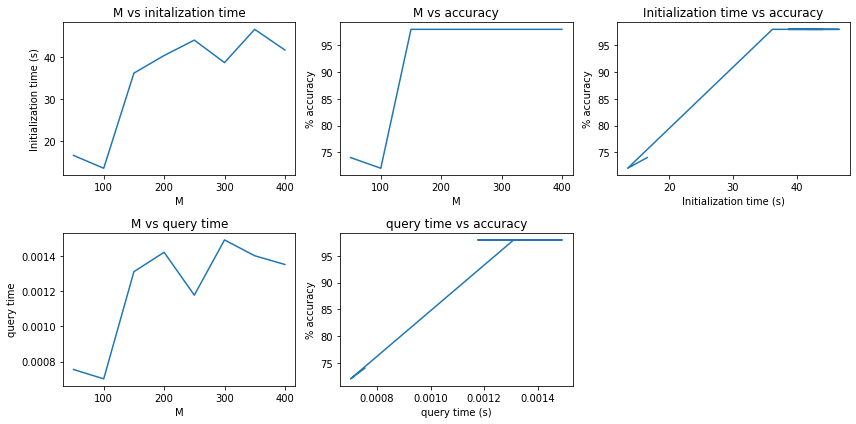

In [51]:
# Evaluate nmslib indexer, changing the parameter M
evaluate_nmslib_performance("M", False, 50, 401, 50)

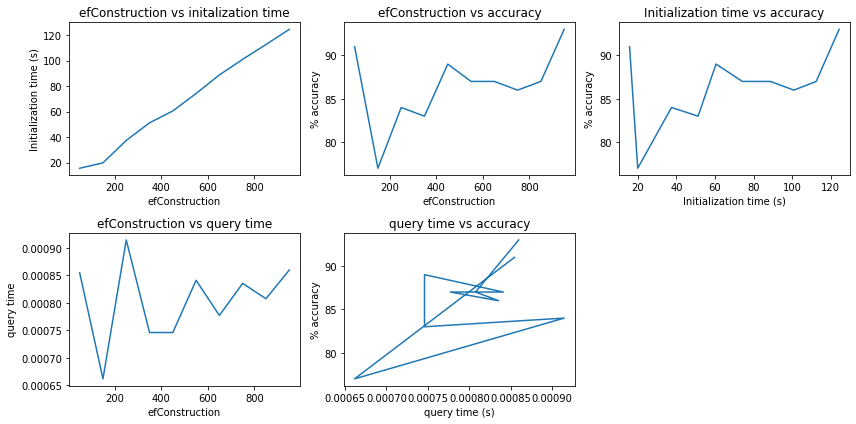

In [52]:
# Evaluate nmslib indexer, changing the parameter efConstruction
evaluate_nmslib_performance("efConstruction", False, 50, 1001, 100)

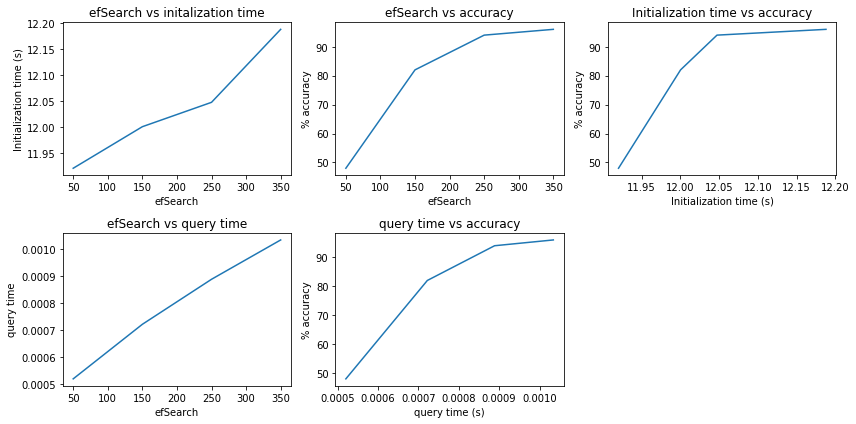

In [53]:
# Evaluate nmslib indexer, changing the parameter efSearch
evaluate_nmslib_performance("efSearch", True, 50, 401, 100)

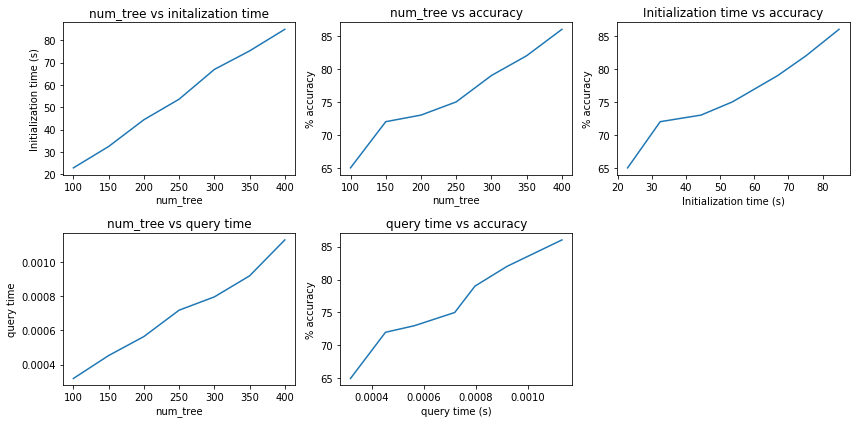

In [54]:
# Evaluate annoy indexer, changing the parameter num_tree
annoy_x_values = []
annoy_y_values_init = []
annoy_y_values_accuracy = []
annoy_y_values_query = []

for x in range(100, 401, 50):
    annoy_x_values.append(x)
    start_time = time.time()
    annoy_index = AnnoyIndexer(model, x)
    annoy_y_values_init.append(time.time() - start_time)
    approximate_results = model.most_similar([model.wv.syn0norm[0]], topn=100, indexer=annoy_index)
    top_words = [result[0] for result in approximate_results]
    annoy_y_values_accuracy.append(len(set(top_words).intersection(exact_results)))
    annoy_y_values_query.append(avg_query_time(annoy_index, queries=queries))
create_evaluation_graph(annoy_x_values,
                        annoy_y_values_init, 
                        annoy_y_values_accuracy, 
                        annoy_y_values_query, 
                        "num_tree")

In [55]:
# nmslib indexer changing the parameter M, efConstruction, efSearch
nmslib_y_values_init = []
nmslib_y_values_accuracy = []
nmslib_y_values_query = []

for M in [100, 200]:
    for efConstruction in [100, 200]:
        for efSearch in [100, 200]:
            start_time = time.time()
            nmslib_index = NmslibIndexer(model, 
                                    {'M': M, 'indexThreadQty': 10, 'efConstruction': efConstruction, 'post': 0},
                                    {'efSearch': efSearch})
            nmslib_y_values_init.append(time.time() - start_time)
            approximate_results = model.most_similar([model.wv.syn0norm[0]], topn=100, indexer=nmslib_index)
            top_words = [result[0] for result in approximate_results]
            nmslib_y_values_accuracy.append(len(set(top_words).intersection(exact_results)))
            nmslib_y_values_query.append(avg_query_time(nmslib_index, queries=queries))


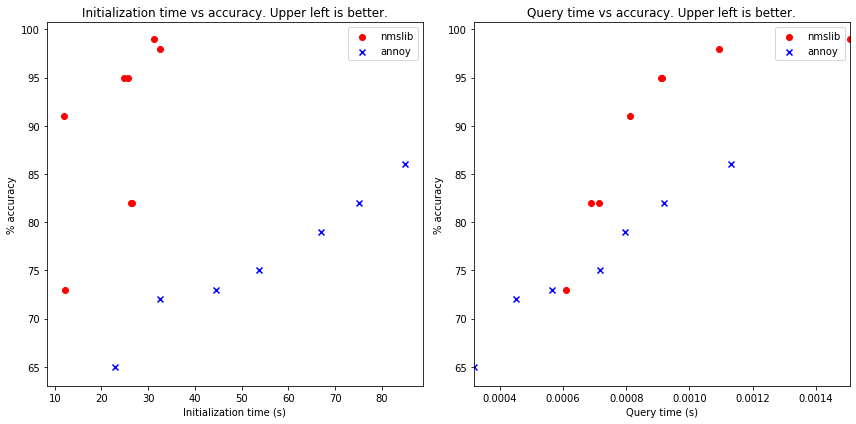

In [56]:
# Make a comparison between annoy and nmslib indexer
plt.figure(1, figsize=(12, 6))
plt.subplot(121)
plt.scatter(nmslib_y_values_init, nmslib_y_values_accuracy, label="nmslib", color='r', marker='o')
plt.scatter(annoy_y_values_init, annoy_y_values_accuracy, label="annoy", color='b', marker='x')
plt.legend()
plt.title("Initialization time vs accuracy. Upper left is better.")
plt.ylabel("% accuracy")
plt.xlabel("Initialization time (s)")
plt.subplot(122)
plt.scatter(nmslib_y_values_query, nmslib_y_values_accuracy, label="nmslib", color='r', marker='o')
plt.scatter(annoy_y_values_query, annoy_y_values_accuracy, label="annoy", color='b', marker='x')
plt.legend()
plt.title("Query time vs accuracy. Upper left is better.")
plt.ylabel("% accuracy")
plt.xlabel("Query time (s)")
plt.xlim(min(nmslib_y_values_query+annoy_y_values_query), max(nmslib_y_values_query+annoy_y_values_query))
plt.tight_layout()
plt.show()

### 6. Work with Google word2vec files

Our model can be exported to a word2vec C format. There is a binary and a plain text word2vec format. Both can be read with a variety of other software, or imported back into gensim as a `KeyedVectors` object.

In [74]:
# To export our model as text
model.wv.save_word2vec_format('/tmp/vectors.txt', binary=False)

In [37]:
from smart_open import open
# View the first 3 lines of the exported file

# The first line has the total number of entries and the vector dimension count. 
# The next lines have a key (a string) followed by its vector.
with open('/tmp/vectors.txt') as myfile:
    for i in range(3):
        print(myfile.readline().strip())

71290 100
the -0.20548718 0.19478682 -0.15149663 -0.31142342 0.014471135 -0.17996445 -0.07373469 0.09573618 -0.06328416 0.15571225 0.021413572 -0.12776679 -0.16940169 0.15807933 -0.21688043 0.074471496 0.08091913 0.07911484 0.31909388 -0.12297766 0.16993207 -0.02962172 0.08481803 0.12566781 0.02949822 -0.009697897 0.10780254 -0.102594994 -0.03935867 0.2679534 -0.061677158 -0.26071545 0.16285498 0.051780242 -0.1697231 0.24037386 0.0726078 -0.090416454 0.0776138 -0.06611322 0.057015926 0.07859522 -0.1910579 0.2974446 -0.033308737 -0.07360004 0.10797568 0.3595622 0.26797494 -0.062491674 0.21733648 -0.08524646 -0.06860078 -0.01714756 0.1305319 -0.09754544 -0.11249808 0.27328265 0.0041686473 -0.09874534 -0.30283058 0.111191 -0.026302295 -0.095534325 -0.0907799 -0.09120328 0.00068672217 0.31802058 -0.03345536 0.103762306 0.068564445 0.07402255 0.013657822 0.020439595 0.14985266 -0.13516407 0.36674532 0.0077319355 0.24709526 0.07666927 -0.11271039 0.02220251 -0.0235162 0.06409378 -0.10098407 

In [38]:
# To import a word2vec text model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)

In [39]:
# To export our model as binary
model.wv.save_word2vec_format('/tmp/vectors.bin', binary=True)

In [40]:
# To import a word2vec binary model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)

In [41]:
# To create and save Nmslib Index from a loaded `KeyedVectors` object 
nmslib_index = NmslibIndexer(wv, 
                            {'M': 100, 'indexThreadQty': 1, 'efConstruction': 100}, {'efSearch': 100})
nmslib_index.save('/tmp/mymodel.index')

In [44]:
# Load and test the saved word vectors and saved nmslib index
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)
nmslib_index = NmslibIndexer.load('/tmp/mymodel.index')
nmslib_index.model = wv

vector = wv["cat"]
approximate_neighbors = wv.most_similar([vector], topn=11, indexer=nmslib_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)

normal_neighbors = wv.most_similar([vector], topn=11)
print("\nNormal (not Nmslib-indexed) Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('cat', 1.0)
('cats', 0.8335747122764587)
('meow', 0.8298084139823914)
('leopardus', 0.8215900659561157)
('albino', 0.8207193315029144)
('poodle', 0.8168523907661438)
('saimiri', 0.8167656660079956)
('squirrel', 0.8138661682605743)
('sighthound', 0.8134040832519531)
('proboscis', 0.8130573630332947)
('eared', 0.812840610742569)

Normal (not Nmslib-indexed) Neighbors
('cat', 1.0)
('cats', 0.6671494245529175)
('meow', 0.6596168279647827)
('leopardus', 0.6431801319122314)
('albino', 0.6414386034011841)
('poodle', 0.633704662322998)
('saimiri', 0.633531391620636)
('squirrel', 0.6277321577072144)
('sighthound', 0.6268081665039062)
('proboscis', 0.6261147260665894)
('eared', 0.6256811618804932)


### Recap
In this notebook we used the Nmslib module to build an indexed approximation of our word embeddings. To do so, we did the following steps:
1. Download Text8 Corpus
2. Build Word2Vec Model
3. Construct NmslibIndex with model & make a similarity query
4. Verify & Evaluate performance
5. Evaluate relationship of parameters to initialization/query time and accuracy, compared with annoy
6. Work with Google's word2vec C formats